In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertTokenizerFast, BertModel
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
em_data = pd.read_csv("./data/BERT_emotion.csv")

# 행동을 설명하는 문장

In [3]:
em_data

,감정,설명
0,행복,낙관적인 생각으로 현재의 감정을 느끼고 즐긴다
1,우울,명상과 운동을 통해 기분을 전환하며 긍정적으로 생각한다
2,슬픔,가족이나 친구를 만나 대화하고 여행 등 활동에 집중한다
3,열정,모험을 시도하며 미래를 상상하고 목표를 세우고 도전한다
4,분노,객관적인 생각으로 마음을 진정시키고 운동을 열심히 한다
5,두려움,순간에 집중하고 대화를 자주하고 용기를 가진다


# 차원을 설명하는 문장

In [4]:
dim_data = pd.read_csv("./data/BERT_dims.csv")

In [5]:
dim_data

,차원,설명
0,에너지,신체에 활력을 불어넣고 활동적이고 열정적이게 한다
1,회복,약해진 몸과 마음을 쉬게 하여 건강한 상태로 복구시킨다
2,순환,호흡과 소화를 활성화하고 영양과 산소 및 에너지를 공급한다
3,정화,잡념과 노폐물을 제거하여 몸과 마음을 깨끗하게 한다


In [6]:
tokenizer = BertTokenizerFast.from_pretrained("kykim/bert-kor-base")
model = BertModel.from_pretrained("kykim/bert-kor-base")

Some weights of the model checkpoint at kykim/bert-kor-base were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# BERT 모델을 사용해서 문장의 유사도 확인
현재 bert의 per-train의 output을 mean_pooling을 이용해서 sent vector로 바꾼 후 유사도를 계산하는 방식

In [7]:
def word_sim(sent1 , sent2):
    words = [sent1, sent2]
    tokens = {'input_ids' : [] , 'attention_mask' : []}

    
    for word in words:
        print(word)
        encoded = tokenizer.encode(word)
        #print(tokenizer.convert_ids_to_tokens(encoded))
        print('토큰의 수 : {} , 토큰화된 문장 {}'.format(len(encoded)-2,tokenizer.convert_ids_to_tokens(encoded)))
        new_tokens = tokenizer.encode_plus(word , max_length=128, truncation= True , padding='max_length' , return_tensors='pt')
        tokens['input_ids'].append(new_tokens['input_ids'][0])
        tokens['attention_mask'].append(new_tokens['attention_mask'][0])
        
    tokens['input_ids'] = torch.stack(tokens['input_ids'])
    tokens['attention_mask'] = torch.stack(tokens['attention_mask'])
    
    outputs = model(**tokens)
    embeddings = outputs.last_hidden_state
    attention_mask = tokens['attention_mask']
    mask = attention_mask.unsqueeze(-1).expand(embeddings.size()).float()
    masked_embeddings = embeddings * mask
    summed = torch.sum(masked_embeddings,1)
    summed_mask = torch.clamp(mask.sum(1), min=1e-9)
    mean_pooled = summed / summed_mask
    mean_pooled = mean_pooled.detach().numpy()
    return cosine_similarity( mean_pooled[0].reshape(1,-1) , mean_pooled[1].reshape(1,-1))[0][0]

In [8]:
em_dim = pd.DataFrame(columns = ['에너지','회복','순환','정화'], index = em_data['감정'])

## 수치화를 진행하면서 token의 수와 tokenize가 잘 되는 지 확인

In [9]:
e_est = []
e_sents = dim_data['설명'][0]
for idx in em_data.index:
    e_est.append(word_sim(e_sents,em_data['설명'][idx]))
    print('\n')
em_dim['에너지'] = e_est

신체에 활력을 불어넣고 활동적이고 열정적이게 한다
토큰의 수 : 11 , 토큰화된 문장 ['[CLS]', '신체', '##에', '활력을', '불어', '##넣고', '활동', '##적이고', '열정', '##적이', '##게', '한다', '[SEP]']
낙관적인 생각으로 현재의 감정을 느끼고 즐긴다
토큰의 수 : 9 , 토큰화된 문장 ['[CLS]', '낙', '##관', '##적인', '생각으로', '현재의', '감정을', '느끼고', '즐', '##긴다', '[SEP]']


신체에 활력을 불어넣고 활동적이고 열정적이게 한다
토큰의 수 : 11 , 토큰화된 문장 ['[CLS]', '신체', '##에', '활력을', '불어', '##넣고', '활동', '##적이고', '열정', '##적이', '##게', '한다', '[SEP]']
명상과 운동을 통해 기분을 전환하며 긍정적으로 생각한다
토큰의 수 : 9 , 토큰화된 문장 ['[CLS]', '명', '##상과', '운동을', '통해', '기분을', '전환', '##하며', '긍정적으로', '생각한다', '[SEP]']


신체에 활력을 불어넣고 활동적이고 열정적이게 한다
토큰의 수 : 11 , 토큰화된 문장 ['[CLS]', '신체', '##에', '활력을', '불어', '##넣고', '활동', '##적이고', '열정', '##적이', '##게', '한다', '[SEP]']
가족이나 친구를 만나 대화하고 여행 등 활동에 집중한다
토큰의 수 : 11 , 토큰화된 문장 ['[CLS]', '가족이', '##나', '친구를', '만나', '대화', '##하고', '여행', '등', '활동에', '집중', '##한다', '[SEP]']


신체에 활력을 불어넣고 활동적이고 열정적이게 한다
토큰의 수 : 11 , 토큰화된 문장 ['[CLS]', '신체', '##에', '활력을', '불어', '##넣고', '활동', '##적이고', '열정', '##적이', '##게', '한다', '[SEP]']
모험을 시도하며 미래를 

In [10]:
h_est = []
h_sents = dim_data['설명'][1]
for idx in em_data.index:
    h_est.append(word_sim(h_sents,em_data['설명'][idx]))
    print('\n')
em_dim['회복'] = h_est

약해진 몸과 마음을 쉬게 하여 건강한 상태로 복구시킨다
토큰의 수 : 11 , 토큰화된 문장 ['[CLS]', '약', '##해진', '몸과', '마음을', '쉬', '##게', '하여', '건강한', '상태로', '복구', '##시킨다', '[SEP]']
낙관적인 생각으로 현재의 감정을 느끼고 즐긴다
토큰의 수 : 9 , 토큰화된 문장 ['[CLS]', '낙', '##관', '##적인', '생각으로', '현재의', '감정을', '느끼고', '즐', '##긴다', '[SEP]']


약해진 몸과 마음을 쉬게 하여 건강한 상태로 복구시킨다
토큰의 수 : 11 , 토큰화된 문장 ['[CLS]', '약', '##해진', '몸과', '마음을', '쉬', '##게', '하여', '건강한', '상태로', '복구', '##시킨다', '[SEP]']
명상과 운동을 통해 기분을 전환하며 긍정적으로 생각한다
토큰의 수 : 9 , 토큰화된 문장 ['[CLS]', '명', '##상과', '운동을', '통해', '기분을', '전환', '##하며', '긍정적으로', '생각한다', '[SEP]']


약해진 몸과 마음을 쉬게 하여 건강한 상태로 복구시킨다
토큰의 수 : 11 , 토큰화된 문장 ['[CLS]', '약', '##해진', '몸과', '마음을', '쉬', '##게', '하여', '건강한', '상태로', '복구', '##시킨다', '[SEP]']
가족이나 친구를 만나 대화하고 여행 등 활동에 집중한다
토큰의 수 : 11 , 토큰화된 문장 ['[CLS]', '가족이', '##나', '친구를', '만나', '대화', '##하고', '여행', '등', '활동에', '집중', '##한다', '[SEP]']


약해진 몸과 마음을 쉬게 하여 건강한 상태로 복구시킨다
토큰의 수 : 11 , 토큰화된 문장 ['[CLS]', '약', '##해진', '몸과', '마음을', '쉬', '##게', '하여', '건강한', '상태로', '복구', '##시킨다', '[SEP]']
모험을 시도하며 미래를 

In [11]:
c_est = []
c_sents = dim_data['설명'][2]
for idx in em_data.index:
    c_est.append(word_sim(c_sents,em_data['설명'][idx]))
    print('\n')
em_dim['순환'] = c_est

호흡과 소화를 활성화하고 영양과 산소 및 에너지를 공급한다
토큰의 수 : 13 , 토큰화된 문장 ['[CLS]', '호흡', '##과', '소화', '##를', '활성화', '##하고', '영양', '##과', '산소', '및', '에너지를', '공급', '##한다', '[SEP]']
낙관적인 생각으로 현재의 감정을 느끼고 즐긴다
토큰의 수 : 9 , 토큰화된 문장 ['[CLS]', '낙', '##관', '##적인', '생각으로', '현재의', '감정을', '느끼고', '즐', '##긴다', '[SEP]']


호흡과 소화를 활성화하고 영양과 산소 및 에너지를 공급한다
토큰의 수 : 13 , 토큰화된 문장 ['[CLS]', '호흡', '##과', '소화', '##를', '활성화', '##하고', '영양', '##과', '산소', '및', '에너지를', '공급', '##한다', '[SEP]']
명상과 운동을 통해 기분을 전환하며 긍정적으로 생각한다
토큰의 수 : 9 , 토큰화된 문장 ['[CLS]', '명', '##상과', '운동을', '통해', '기분을', '전환', '##하며', '긍정적으로', '생각한다', '[SEP]']


호흡과 소화를 활성화하고 영양과 산소 및 에너지를 공급한다
토큰의 수 : 13 , 토큰화된 문장 ['[CLS]', '호흡', '##과', '소화', '##를', '활성화', '##하고', '영양', '##과', '산소', '및', '에너지를', '공급', '##한다', '[SEP]']
가족이나 친구를 만나 대화하고 여행 등 활동에 집중한다
토큰의 수 : 11 , 토큰화된 문장 ['[CLS]', '가족이', '##나', '친구를', '만나', '대화', '##하고', '여행', '등', '활동에', '집중', '##한다', '[SEP]']


호흡과 소화를 활성화하고 영양과 산소 및 에너지를 공급한다
토큰의 수 : 13 , 토큰화된 문장 ['[CLS]', '호흡', '##과', '소화', '##를', '활성화', '##하고', '영양'

In [12]:
p_est = []
p_sents = dim_data['설명'][3]
for idx in em_data.index:
    p_est.append(word_sim(p_sents,em_data['설명'][idx]))
    print('\n')
em_dim['정화'] = p_est

잡념과 노폐물을 제거하여 몸과 마음을 깨끗하게 한다
토큰의 수 : 10 , 토큰화된 문장 ['[CLS]', '잡', '##념', '##과', '노폐물을', '제거', '##하여', '몸과', '마음을', '깨끗하게', '한다', '[SEP]']
낙관적인 생각으로 현재의 감정을 느끼고 즐긴다
토큰의 수 : 9 , 토큰화된 문장 ['[CLS]', '낙', '##관', '##적인', '생각으로', '현재의', '감정을', '느끼고', '즐', '##긴다', '[SEP]']


잡념과 노폐물을 제거하여 몸과 마음을 깨끗하게 한다
토큰의 수 : 10 , 토큰화된 문장 ['[CLS]', '잡', '##념', '##과', '노폐물을', '제거', '##하여', '몸과', '마음을', '깨끗하게', '한다', '[SEP]']
명상과 운동을 통해 기분을 전환하며 긍정적으로 생각한다
토큰의 수 : 9 , 토큰화된 문장 ['[CLS]', '명', '##상과', '운동을', '통해', '기분을', '전환', '##하며', '긍정적으로', '생각한다', '[SEP]']


잡념과 노폐물을 제거하여 몸과 마음을 깨끗하게 한다
토큰의 수 : 10 , 토큰화된 문장 ['[CLS]', '잡', '##념', '##과', '노폐물을', '제거', '##하여', '몸과', '마음을', '깨끗하게', '한다', '[SEP]']
가족이나 친구를 만나 대화하고 여행 등 활동에 집중한다
토큰의 수 : 11 , 토큰화된 문장 ['[CLS]', '가족이', '##나', '친구를', '만나', '대화', '##하고', '여행', '등', '활동에', '집중', '##한다', '[SEP]']


잡념과 노폐물을 제거하여 몸과 마음을 깨끗하게 한다
토큰의 수 : 10 , 토큰화된 문장 ['[CLS]', '잡', '##념', '##과', '노폐물을', '제거', '##하여', '몸과', '마음을', '깨끗하게', '한다', '[SEP]']
모험을 시도하며 미래를 상상하고 목표를 세우고 도전한다
토큰의 수 : 11

# 감정 - 차원에 대한 유사도 확인

In [13]:
dim_data

,차원,설명
0,에너지,신체에 활력을 불어넣고 활동적이고 열정적이게 한다
1,회복,약해진 몸과 마음을 쉬게 하여 건강한 상태로 복구시킨다
2,순환,호흡과 소화를 활성화하고 영양과 산소 및 에너지를 공급한다
3,정화,잡념과 노폐물을 제거하여 몸과 마음을 깨끗하게 한다


In [14]:
em_data

,감정,설명
0,행복,낙관적인 생각으로 현재의 감정을 느끼고 즐긴다
1,우울,명상과 운동을 통해 기분을 전환하며 긍정적으로 생각한다
2,슬픔,가족이나 친구를 만나 대화하고 여행 등 활동에 집중한다
3,열정,모험을 시도하며 미래를 상상하고 목표를 세우고 도전한다
4,분노,객관적인 생각으로 마음을 진정시키고 운동을 열심히 한다
5,두려움,순간에 집중하고 대화를 자주하고 용기를 가진다


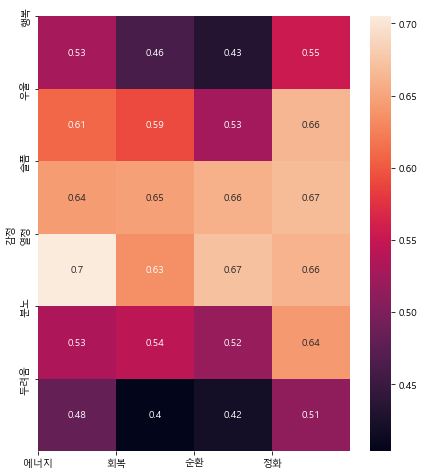

In [15]:
plt.rc('font', family='Malgun Gothic')
dim_list = ['에너지','회복','순환','정화']

fig = plt.figure(figsize=(7,8))
fig.set_facecolor('white')
#plt.title(f'{act_name}에서 단어들간의 유사도 확인')
sns.heatmap(em_dim,cbar=True,annot=True)
plt.xticks(np.arange(len(dim_list)),dim_list)
plt.yticks(np.arange(len(em_data['감정'])),em_data['감정'])
plt.show()


* 변경


|action|설명(행동의 설명하는 문장을 보고 차원과 직접 매핑)|타당?|
|--|--|--|
|명상|(몸을 이완 -> 회복) , (마음을 안정 -> 정화)|타당|  
|산책|(순환 키워드/혈액 순환 , 순환) , (창의성/상쾌하게, 에너지,정화)|타당|
|등산|(정화 키워드, 정화) (몸을 튼튼,회복)|타당|
샤워|(노폐물 제거 , 정화) , (혈액순환 , 순환)|타당|
|수영|(근력 향샹/체중관리 , 회복)|애매|
|조깅|(심페기능 강화, 회복/순화) , (스트레스 해소, 정화)|애매|
|자전거 타기|(심폐기능, 순환/회복) , (관절/근력 강화, 회복) , (스트레스,정화)|애매|
|요가|(유연성/힘 상승, 회복) , (스트레스 해소/정화)|애매|
|스트레칭|(회복 키워드 , 회복), (혈액 순환 , 순환)|타당|
|여행|(행복감/창의성, 에너지) , (기분전환,정화/에너지)|타당|


In [16]:
em_dim

,에너지,회복,순환,정화
감정,,,,
행복,0.527631,0.462057,0.431907,0.554165
우울,0.609448,0.590981,0.525570,0.663310
슬픔,0.644105,0.647081,0.659151,0.666777
열정,0.704861,0.634988,0.671534,0.661103
분노,0.531844,0.544327,0.517364,0.641701
두려움,0.482347,0.403523,0.419381,0.512514


C:\Users\fd\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\fd\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


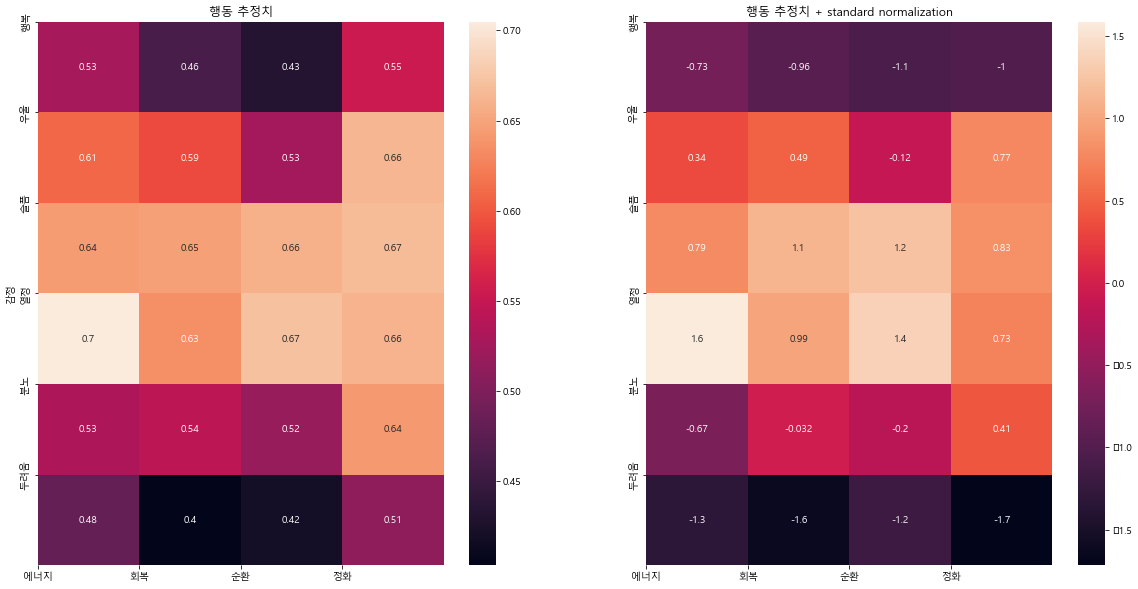

In [17]:
# 현재 행동 추정치를 standard normalization
from sklearn.preprocessing import StandardScaler
'''
std_est = []
for idx in em_dim.index:
    scaler = StandardScaler()
    act_est = np.array(em_dim.loc[idx]).reshape(-1,1)
    scaler.fit(act_est)
    std_act_est = scaler.transform(act_est).reshape(1,4).flatten()
    std_est.append(std_act_est)
'''

std_est = []
for col in em_dim.columns:
    s_scaler = StandardScaler()
    dim_ests = np.array(em_dim[col]).reshape(-1,1) 
    s_scaler.fit(dim_ests)
    std_dim_est = s_scaler.transform(dim_ests).flatten()
    std_est.append(std_dim_est)

std_est = np.array(std_est).T


plt.rc('font', family='Malgun Gothic')
f,(ax1,ax2) = plt.subplots(1,2)
f.set_figheight(10)
f.set_figwidth(20)
action_list = ['명상' , '산책' , '등산' , '샤워' , '수영' , '조깅' , '자전거 타기' , '요가' , '스트레칭' , '여행']
dim_list = ['에너지','회복','순환','정화']


g1 = sns.heatmap(em_dim,cbar=True,annot=True , ax=ax1)
ax1.set_title('행동 추정치')
ax1.set_yticks(np.arange(0,len(em_data['감정'])))
ax1.set_yticklabels(em_data['감정'])
ax1.set_xticks(np.arange(0,len(dim_list)))
ax1.set_xticklabels(dim_list)

g2 = sns.heatmap(std_est,cbar=True,annot=True, ax=ax2)
ax2.set_title('행동 추정치 + standard normalization')
ax2.set_yticks(np.arange(0,len(em_data['감정'])))
ax2.set_yticklabels(em_data['감정'])
ax2.set_xticks(np.arange(0,len(dim_list)))
ax2.set_xticklabels(dim_list)

plt.show()

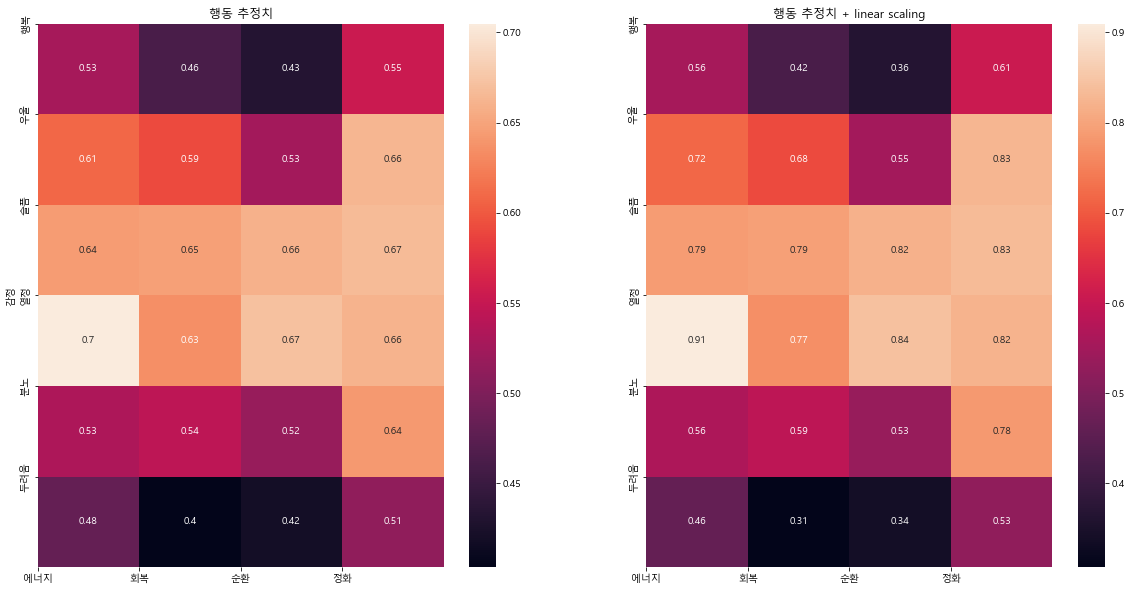

In [18]:
# 현재 행동 추정치를 linear scaling ( 2 * est - 0.7)
lin_est = []
for idx in em_dim.index:
    act_est = np.array(em_dim.loc[idx])
    std = np.std(act_est)
    nor_act_est =  (2 * act_est) - 0.5
    lin_est.append(nor_act_est)

plt.rc('font', family='Malgun Gothic')
f,(ax1,ax2) = plt.subplots(1,2)
f.set_figheight(10)
f.set_figwidth(20)
action_list = ['명상' , '산책' , '등산' , '샤워' , '수영' , '조깅' , '자전거 타기' , '요가' , '스트레칭' , '여행']
dim_list = ['에너지','회복','순환','정화']

g1 = sns.heatmap(em_dim,cbar=True,annot=True , ax=ax1)
ax1.set_title('행동 추정치')
ax1.set_yticks(np.arange(0,len(em_data['감정'])))
ax1.set_yticklabels(em_data['감정'])
ax1.set_xticks(np.arange(0,len(dim_list)))
ax1.set_xticklabels(dim_list)

g2 = sns.heatmap(lin_est,cbar=True,annot=True, ax=ax2)
ax2.set_title('행동 추정치 + linear scaling')
ax2.set_yticks(np.arange(0,len(em_data['감정'])))
ax2.set_yticklabels(em_data['감정'])
ax2.set_xticks(np.arange(0,len(dim_list)))
ax2.set_xticklabels(dim_list)

plt.show()

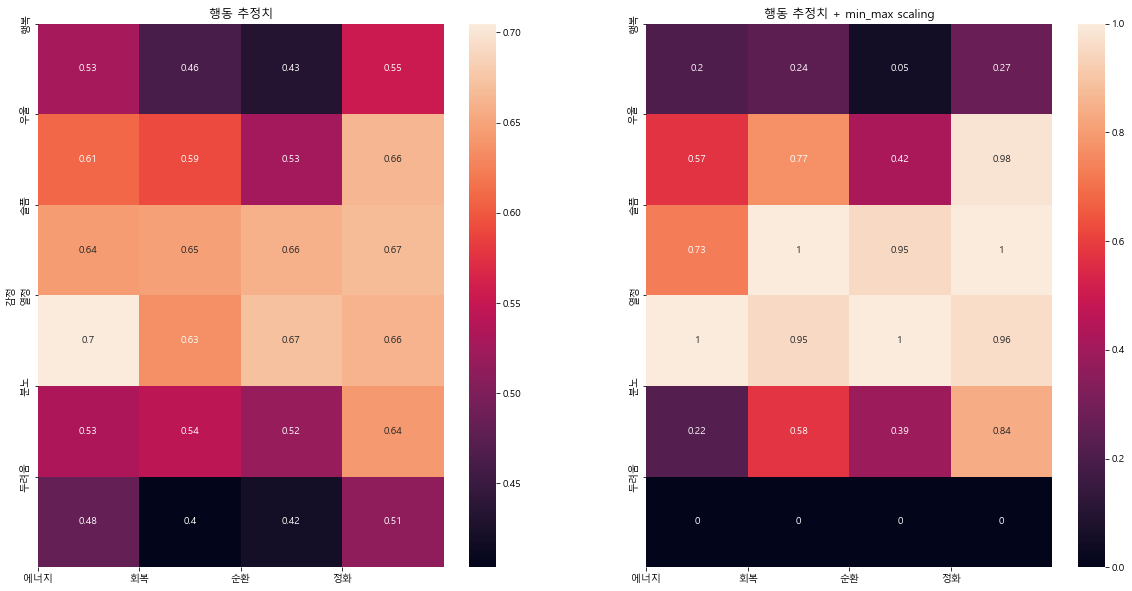

In [19]:
from sklearn.preprocessing import MinMaxScaler
'''
min_max_est = []
for idx in em_dim.index:
    scaler = MinMaxScaler()
    act_est = np.array(em_dim.loc[idx]).reshape(-1,1)
    scaler.fit(act_est)
    normal_act_est = scaler.transform(act_est).reshape(1,4).flatten()
    min_max_est.append(normal_act_est)
'''

min_max_est = []
for col in em_dim.columns:
    m_scaler = MinMaxScaler()
    dim_ests = np.array(em_dim[col]).reshape(-1,1) 
    m_scaler.fit(dim_ests)
    min_dim_est = m_scaler.transform(dim_ests).flatten()
    min_max_est.append(min_dim_est)

min_max_est = np.array(min_max_est).T


plt.rc('font', family='Malgun Gothic')
f,(ax1,ax2) = plt.subplots(1,2)
f.set_figheight(10)
f.set_figwidth(20)
action_list = ['명상' , '산책' , '등산' , '샤워' , '수영' , '조깅' , '자전거 타기' , '요가' , '스트레칭' , '여행']
dim_list = ['에너지','회복','순환','정화']

g1 = sns.heatmap(em_dim,cbar=True,annot=True , ax=ax1)
ax1.set_title('행동 추정치')
ax1.set_yticks(np.arange(0,len(em_data['감정'])))
ax1.set_yticklabels(em_data['감정'])
ax1.set_xticks(np.arange(0,len(dim_list)))
ax1.set_xticklabels(dim_list)

g2 = sns.heatmap(min_max_est,cbar=True,annot=True, ax=ax2)
ax2.set_title('행동 추정치 + min_max scaling')
ax2.set_yticks(np.arange(0,len(em_data['감정'])))
ax2.set_yticklabels(em_data['감정'])
ax2.set_xticks(np.arange(0,len(dim_list)))
ax2.set_xticklabels(dim_list)

plt.show()

C:\Users\fd\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\fd\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


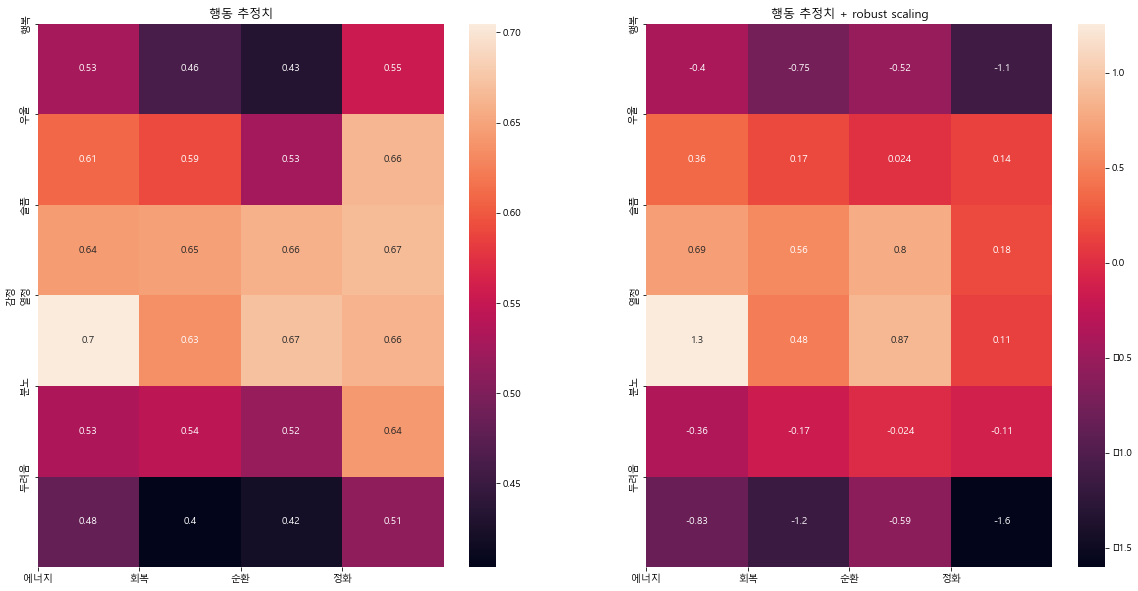

In [20]:
from sklearn.preprocessing import robust_scale
'''
rob_est = []
for idx in em_dim.index:
    act_est = np.array(em_dim.loc[idx]).reshape(-1,1)
    scaler = robust_scale(act_est)
    normal_act_est = np.array(scaler.tolist()).flatten()
    rob_est.append(normal_act_est)
'''

rob_est = []
for col in em_dim.columns:
    dim_ests = np.array(em_dim[col]).reshape(-1,1) 
    scaler = robust_scale(dim_ests)
    rob_dim_est = np.array(scaler.tolist()).flatten()
    rob_est.append(rob_dim_est)

rob_est = np.array(rob_est).T


plt.rc('font', family='Malgun Gothic')
f,(ax1,ax2) = plt.subplots(1,2)
f.set_figheight(10)
f.set_figwidth(20)
action_list = ['명상' , '산책' , '등산' , '샤워' , '수영' , '조깅' , '자전거 타기' , '요가' , '스트레칭' , '여행']
dim_list = ['에너지','회복','순환','정화']

g1 = sns.heatmap(em_dim,cbar=True,annot=True , ax=ax1)
ax1.set_title('행동 추정치')
ax1.set_yticks(np.arange(0,len(em_data['감정'])))
ax1.set_yticklabels(em_data['감정'])
ax1.set_xticks(np.arange(0,len(dim_list)))
ax1.set_xticklabels(dim_list)

g2 = sns.heatmap(rob_est,cbar=True,annot=True, ax=ax2)
ax2.set_title('행동 추정치 + robust scaling')
ax2.set_yticks(np.arange(0,len(em_data['감정'])))
ax2.set_yticklabels(em_data['감정'])
ax2.set_xticks(np.arange(0,len(dim_list)))
ax2.set_xticklabels(dim_list)

plt.show()

In [22]:
em_dim.to_csv('./result/em2dim.csv')